In [226]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from LabFuncs import *
from WIMPFuncs import *
from NeutrinoFuncs import *
from Params import *
from scipy.stats import norm
import cmocean
from Params import *


#####

def GetMaps(m_chi,sigma_p,Nuc,E_th,E_max,t,ne,n):
    DM = WIMP(m_chi,sigma_p)
    HaloModel = SHM
    Loc = Boulby
    NuBG = GetNuFluxes(0.0,Nuc)
    E_nu_all = NuBG.Energy
    Flux_all = NuBG.Flux
    n_nu = NuBG.NumberOfNeutrinos 
    Errs = NuBG.Uncertainties
    E_r_vals = linspace(E_th,E_max,ne)
    dE = E_r_vals[1]-E_r_vals[0]
    nn = int(n*n/2)
    PH, TH = meshgrid(linspace(0, 2*pi, n), linspace(-pi/2, pi/2, int(n/2)))
    X = cos(PH)*cos(TH)
    Y = -sin(PH)*cos(TH)
    Z = sin(TH)
    ii = 0
    q = zeros(shape=(nn,3))
    for i in range(0,int(n/2)):
        for j in range(0,n):
            q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
            ii = ii+1

    def Get_q_lab(JD):
        lat = Loc.Latitude
        lon = Loc.Longitude
        UT = 24*(JD+0.5-floor(JD+0.5))
        MJD = JD - 2400000.5
        T_0 = (floor(MJD)-55197.5)/36525.0
        t_GAST = (101.0308 + 36000.770*T_0 + 15.04107*UT)/15.0
        t_lab = t_GAST + lon/15.0
        t_lab = 15*t_lab # DEGREES
        q_lab = zeros(shape=shape(q))
        for i in range(0,shape(q)[0]):
            q_lab[i,:] =  gal2lab(q[i,:],t_lab, lat)
        return q_lab

    def convertmap(R3D):
        R_map = zeros(shape=(int(n/2),n))
        ii = 0
        for i in range(0,int(n/2)):
            for j in range(0,n):
                R_map[i,j] = R3D[0,ii]
                ii = ii+1
        R_map = flipud(R_map)
        return R_map

    dR_wimp = zeros(shape=(1,int(n*n/2)))
    dR_nu = zeros(shape=(1,int(n*n/2)))
    q_lab = Get_q_lab(t)
    for i in range(0,ne):
        E = -1*E_r_vals[i]*q_lab
        dR_wimp = dR_wimp + dRdEdO_wimp(E,t*ones(shape=int(n*n/2)),DM,HaloModel,Nuc,Loc)*dE
        dR_nu = dR_nu + dRdEdO_solarnu(E,t*ones(shape=int(n*n/2)),E_nu_all[:,5],Flux_all[:,5],Nuc,Loc)*dE
    dR_wimp = dR_wimp
    dR_nu = dR_nu

    dR_mapw = zeros(shape=(int(n/2),n))
    dR_mapn = zeros(shape=(int(n/2),n))
    ii = 0
    for i in range(0,int(n/2)):
        for j in range(0,n):
            dR_mapw[i,j] = dR_wimp[0,ii]
            dR_mapn[i,j] = dR_nu[0,ii]
            ii = ii+1
    return PH,TH,dR_mapw,dR_mapn

In [27]:
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as colors

plt.rcParams['axes.linewidth'] = 3
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=15)

cyg = array([[ 62.10963941,   4.57150891],
       [ 71.01544763,   3.3646167 ],
       [ 78.14859103,   1.86708845],
       [ 84.28473664,   1.99754612],
       [ 78.14859103,   1.86708845],
       [ 78.70955616,  10.24302209],
       [ 83.61190613,  15.44876931],
       [ 84.40177176,  17.85322722],
       [ 83.61190613,  15.44876931],
       [ 78.70955616,  10.24302209],
       [ 78.14859103,   1.86708845],
       [ 75.95136158,  -5.71541249],
       [ 76.75381354, -12.45226928]])

Months = array(['January','February','March','April','May','June','July','August','September','October','November','December'])
datecumsum = cumsum(array([31,28,31,30,31,30,31,31,30,31,30,31]))

def Psun(JD):
    lat = Loc.Latitude
    lon = Loc.Longitude
    UT = 24*(JD+0.5-floor(JD+0.5))
    MJD = JD - 2400000.5
    T_0 = (floor(MJD)-55197.5)/36525.0
    t_GAST = (101.0308 + 36000.770*T_0 + 15.04107*UT)/15.0
    t_lab = t_GAST + lon/15.0
    t_lab = 15*t_lab # DEGREES
    q_sun = lab2gal(SolarDirection(JD,Loc),t_lab,lat)
    return array([arctan2(-q_sun[1],q_sun[0]),arcsin(q_sun[2])])*180/pi

def xlab(JD):
    lat = Loc.Latitude
    lon = Loc.Longitude
    UT = 24*(JD+0.5-floor(JD+0.5))
    MJD = JD - 2400000.5
    T_0 = (floor(MJD)-55197.5)/36525.0
    t_GAST = (101.0308 + 36000.770*T_0 + 15.04107*UT)/15.0
    t_lab = t_GAST + lon/15.0
    t_lab = 15*t_lab # DEGREES
    q_lab = lab2gal(LabVelocity(JD,Boulby,SHM),t_lab,lat)
    q_lab = q_lab/sqrt(sum(q_lab**2.0))
    return array([arctan2(-q_lab[1],q_lab[0]),arcsin(q_lab[2])])*180/pi

# ecliptic
ntt = 200
times = Jan1+linspace(0,364,ntt)
ecl = zeros(shape=(ntt,2))
cygabb = zeros(shape=(ntt,2))
for i in range(0,ntt):
    JD = times[i]
    ecl[i,:] = Psun(times[i])
    cygabb[i,:] = xlab(times[i])
ecl = ecl[argsort(ecl[:,0]),:]


In [257]:
ti = 250
ne = 50
n = 200
m_chi = 9.0
sigma_p = 5.0e-45
E_th = 8.0
E_max = 50.0
PH,TH,dR_mapw,dR_mapn = GetMaps(m_chi,sigma_p,F19,E_th,E_max,Jan1+ti,ne,n)

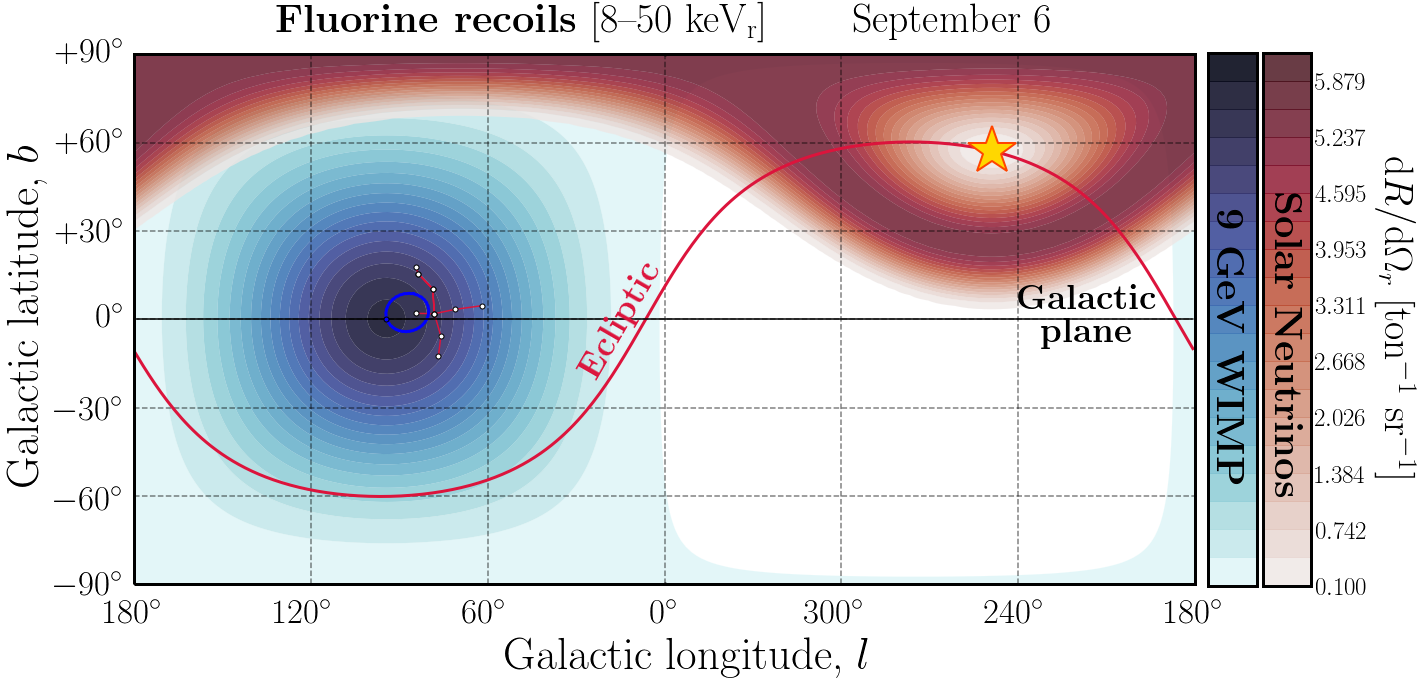

In [280]:
#cmax = amax(dR_mapw)
nlevels = 20
cmax = 6.2
cmin = 0.1
levels = linspace(cmin,cmax,nlevels)
    
cmap_w = cmocean.cm.ice_r
cmap_nu = cmocean.cm.amp
tfs = 35
gridlinecolor = 'k'

# Set up figure
fig, axarr = plt.subplots(1, 1,figsize=(19,10))
gs = gridspec.GridSpec(1, 1)
gs.update(wspace=0.1)

# PlateCarree
ax = plt.subplot(gs[0],projection=ccrs.PlateCarree())
xtx = array([-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01])
ytx = array([0.0,0.16,0.33,0.5,0.66,0.83,1.0])
tx = array([r'$-90^\circ$',r'$-60^\circ$',r'$-30^\circ$',r'$0^\circ$',r'$+30^\circ$',r'$+60^\circ$',r'$+90^\circ$']) 
xtx_l = array([0.0,0.16,0.33,0.5,0.66,0.83,1.0])
ytx_l = array([-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03])
tx_l = array([r'$180^\circ$',r'$120^\circ$',r'$60^\circ$',r'$0^\circ$',r'$300^\circ$',r'$240^\circ$',r'$180^\circ$']) 


# Axis lines
gl = ax.gridlines(color=gridlinecolor,linewidth=1.5, linestyle='--',alpha=0.5)
gl.ylocator = mticker.FixedLocator([-90,-60, -30, 0, 30, 60,90])
ax.outline_patch.set_linewidth(3)

for i in range(0,size(xtx)):
    plt.text(xtx[i],ytx[i],tx[i],transform=ax.transAxes,horizontalalignment='right',verticalalignment='center',fontsize=tfs)
    plt.text(xtx_l[i],ytx_l[i],tx_l[i],transform=ax.transAxes,horizontalalignment='center',verticalalignment='top',fontsize=tfs)

ax.plot(-cyg[0:4,0],cyg[0:4,1],'-',color='crimson',transform=ccrs.PlateCarree())
ax.plot(-cyg[4:,0],cyg[4:,1],'-',color='crimson',transform=ccrs.PlateCarree())
ax.plot(-cyg[:,0],cyg[:,1],'.',color='w',ms=10,mec='k',lw=1.5,transform=ccrs.PlateCarree())
ax.text(120,3,r'{\bf Galactic}',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=tfs)
ax.text(128,-8,r'{\bf plane}',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=tfs)
ax.plot(ecl[:,0],ecl[:,1],'-',lw=3,color='crimson',transform=ccrs.PlateCarree())
ax.plot(cygabb[:,0],cygabb[:,1],'-',lw=3,color='blue',transform=ccrs.PlateCarree())
ax.plot(xlab(ti+Jan1)[0],xlab(ti+Jan1)[1],'.',ms=10,color='blue',mec='k',lw=1.5,transform=ccrs.PlateCarree(),zorder=10)

ax.text(-30,-20,r'{\bf Ecliptic}',color='crimson',transform=ccrs.PlateCarree(),fontsize=tfs,rotation=60)

ax.plot(Psun(Jan1+ti)[0],Psun(Jan1+ti)[1],'*',ms=50,markerfacecolor='gold',mec='orangered',mew=2,transform=ccrs.PlateCarree())

im1 = ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapw,levels=levels,transform=ccrs.PlateCarree(),cmap=cmap_w,vmin=cmin,vmax=cmax,linestyles='none',zorder=0,alpha=0.9,antialiased=True)
ax.contour(rad2deg(PH), rad2deg(TH), dR_mapw,levels=levels,transform=ccrs.PlateCarree(),cmap=cmap_w,vmin=cmin,vmax=cmax,zorder=1,linewidths=0.1,alpha=0.9)


im2 = ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapn,levels=levels,transform=ccrs.PlateCarree(),cmap=cmap_nu,vmin=cmin,vmax=cmax,linestyles='none',zorder=1,alpha=0.8,antialiased=True)
ax.contour(rad2deg(PH), rad2deg(TH), dR_mapn,levels=levels,transform=ccrs.PlateCarree(),cmap=cmap_nu,vmin=cmin,vmax=cmax,zorder=2,linewidths=0.1,alpha=0.8)

#ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapn,levels=levels,transform=ccrs.PlateCarree(),cmap=cmap_nu,vmin=cmin,vmax=cmax,alpha=0.0,linestyles='none',antialiased=True,edgecolor='face')



ax.text(0.35,-0.16,'Galactic longitude, $l$',transform=ax.transAxes,fontsize=tfs+10)
ax.text(-0.12,0.2,'Galactic latitude, $b$',transform=ax.transAxes,fontsize=tfs+10,rotation=90)

ax.plot([0,0],[-90,90],'.',color=gridlinecolor,transform=ccrs.PlateCarree())
ax.plot([-181,181],[0,0],'-',color=gridlinecolor,lw=1.5,transform=ccrs.PlateCarree())
ax.set_title(r'{\bf Fluorine recoils} [8--50 keV$_{\rm r}$] \quad \quad September 6',fontsize=tfs+5,pad=15)


# # Now adding the colorbar
#lf = array([[cmax,0],[cmin,0]])
cbar_ax1 = fig.add_axes([0.92-0.01, 0.132, 0.2, 0.74])
cbar1 = plt.colorbar(im1,extend='max',use_gridspec=True,ticks=[],aspect=11,fraction=1.0)
cbar_ax1.axis('off')

cbar_ax2 = fig.add_axes([0.96-0.01, 0.132, 0.2, 0.74])
cbar2 = plt.colorbar(im2,extend='max',use_gridspec=True,aspect=11,fraction=1.0)
cbar2.ax.tick_params(labelsize=25)
cbar2.set_label(label=r'$\textrm{d}R/\textrm{d}\Omega_r$ [ton$^{-1}$ sr$^{-1}$]',fontsize=40,rotation=-90,labelpad=45)
cbar_ax2.axis('off')
cbar1.ax.tick_params(size=0)
cbar2.ax.tick_params(size=0)
#cbar1.solids.set(alpha=0.5)
#cbar2.solids.set(alpha=0.5)
#cbar1.solids.set_edgecolor("face")
cbar1.solids.set_rasterized(True) 
#cbar2.solids.set_edgecolor("face")
cbar2.solids.set_rasterized(True) 



plt.gcf().text(0.952,0.25,r'{\bf Solar Neutrinos}',rotation=-90,color='k',fontsize=40,verticalalignment='bottom')
plt.gcf().text(0.91,0.27,r'{\bf 9 GeV WIMP}',rotation=-90,color='k',fontsize=40,verticalalignment='bottom')

plt.show()
fig.savefig('../plots/Skymaps.pdf',bbox_inches='tight')

